# Machine Learning for TTC

## Describing the data

In [153]:
import pandas as pd
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

df = pd.read_csv('ttc-data.csv')

df.head(10)

,Report_Date,Route,Time,Day,Location,Incident,Min_Delay,Min_Gap,Direction,Vehicle,Round_Time
0,2014-01-02,505,06:31:00,Thursday,dundas_and_roncesvalles,late_leaving_garage,4.0,8.0,E/B,4018.0,06:30:00
1,2014-01-02,504,12:43:00,Thursday,king_and_shaw,utilized_off_route,20.0,22.0,E/B,4128.0,12:30:00
2,2014-01-02,501,14:01:00,Thursday,kingston_road_and_bingham,held_by,13.0,19.0,W/B,4016.0,14:00:00
3,2014-01-02,504,14:22:00,Thursday,king_st._and_roncesvalles_ave.,investigation,7.0,11.0,W/B,4175.0,14:30:00
4,2014-01-02,504,16:42:00,Thursday,king_and_bathurst,utilized_off_route,3.0,6.0,E/B,4080.0,16:30:00
5,2014-01-02,501,17:39:00,Thursday,queen_and_beaconsfeild,held_by,7.0,13.0,W/B,4202.0,17:30:00
6,2014-01-02,504,18:38:00,Thursday,roncesvalles_and_king_street_west,utilized_off_route,4.0,7.0,E/B,4100.0,18:30:00
7,2014-01-02,510,19:27:00,Thursday,spadina_and_st._andrews,investigation,20.0,22.0,S/B,4123.0,19:30:00
8,2014-01-03,504,01:00:00,Friday,broadview_and_queen,utilized_off_route,7.0,14.0,W/B,4079.0,01:00:00
9,2014-01-03,512,05:09:00,Friday,bathurst_and_st._clair,mechanical,3.0,6.0,E/B,4160.0,05:00:00


In [154]:
df.describe()

,Min_Delay,Min_Gap,Vehicle
count,9077.000000,9075.000000,8577.000000
mean,10.974661,16.521873,4266.468346
std,22.041684,21.190334,1380.678940
min,0.000000,0.000000,0.000000
25%,5.000000,9.000000,4080.000000
50%,6.000000,12.000000,4191.000000
75%,10.000000,18.000000,4446.000000
max,600.000000,535.000000,9446.000000


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9080 entries, 0 to 9079
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Report_Date  9080 non-null   object 
 1   Route        9078 non-null   object 
 2   Time         9080 non-null   object 
 3   Day          9080 non-null   object 
 4   Location     9059 non-null   object 
 5   Incident     9080 non-null   object 
 6   Min_Delay    9077 non-null   float64
 7   Min_Gap      9075 non-null   float64
 8   Direction    8982 non-null   object 
 9   Vehicle      8577 non-null   float64
 10  Round_Time   9080 non-null   object 
dtypes: float64(3), object(8)
memory usage: 780.4+ KB


## Data Cleaning

### Replace NaN with 0

In [156]:
df['Min_Gap'] = df['Min_Gap'].fillna(0)
df['Min_Delay'] = df['Min_Delay'].fillna(0)
df['Route'] = df['Route'].fillna('0')
df['Location'] = df['Location'].fillna('NA')
df['Direction'] = df['Direction'].fillna('NA')
df['Direction'].isna().sum()


0

## Exploring the Data

<AxesSubplot:xlabel='Min_Gap', ylabel='Min_Delay'>

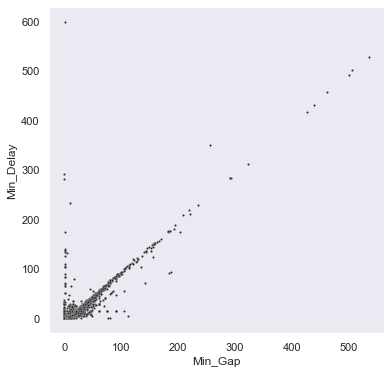

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=df['Min_Gap'], y=df['Min_Delay'], s=5, color=".15")

<AxesSubplot:xlabel='Incident', ylabel='Min_Delay'>

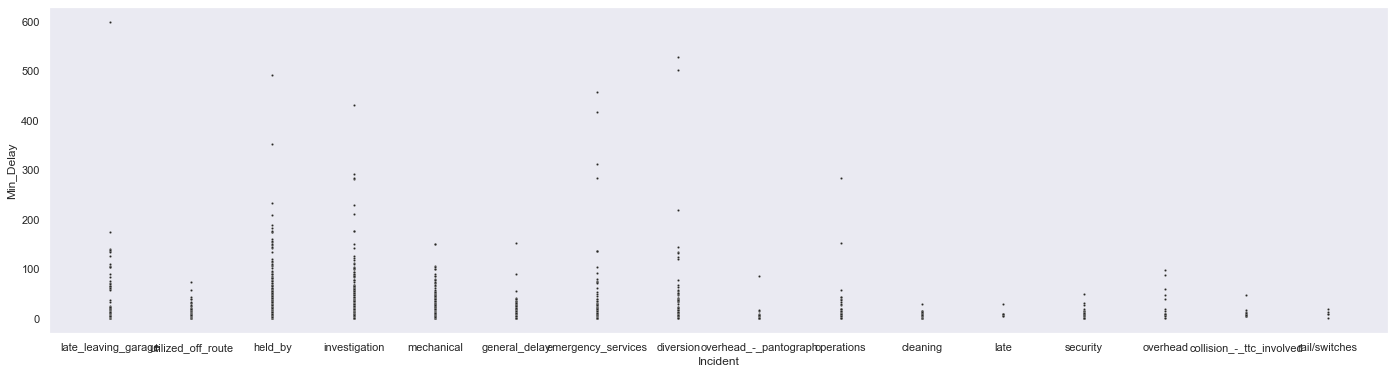

In [158]:
sns.set_theme(style="dark")

f, ax = plt.subplots(figsize=(24, 6))
sns.scatterplot(x=df['Incident'], y=df['Min_Delay'], s=5, color=".15")

<Figure size 1440x288 with 0 Axes>

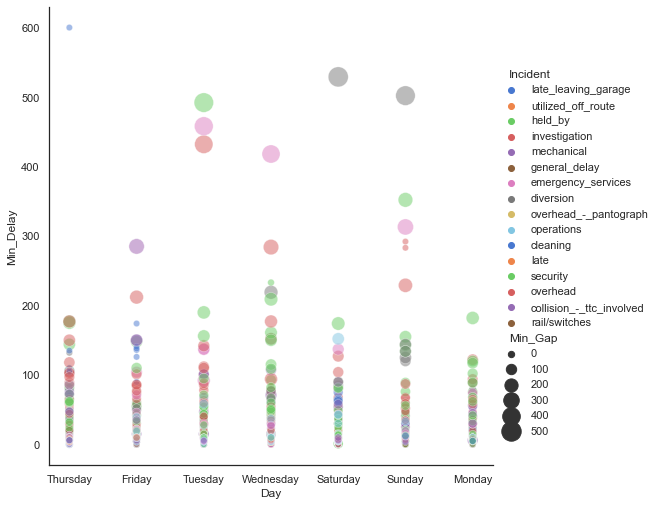

In [159]:
sns.set_theme(style="white")


plt.figure(figsize=(20,4))
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x=df['Reported_'], y=df['Min_Delay'], hue=df['Incident'], size=df['Min_Gap'],
            sizes=(40, 400), alpha=.5, palette="muted",
            height=7)


## Classification Model

### Preparation

In [160]:
# Splitting
df_class = df.drop('Report_Date', axis=1)
df_class = df_class.drop('Vehicle', axis=1)
df_class = df_class.drop('Round_Time', axis=1)

training = df_class.head(6355)
holdout_set = training.sample(1000, random_state=1) # pick 5000 observations randomly
training = training.drop(holdout_set.index) # Remove holdout from training data
testing = df_class.tail(2724)

# Splitting training/testing set to feature (X) and labels (y)
train_y = training.Min_Delay
train_X = training.drop('Min_Delay', axis=1)

test_X = testing.drop('Min_Delay', axis=1)

train_X
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5355 entries, 0 to 6354
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Route      5355 non-null   object 
 1   Time       5355 non-null   object 
 2   Day        5355 non-null   object 
 3   Location   5355 non-null   object 
 4   Incident   5355 non-null   object 
 5   Min_Gap    5355 non-null   float64
 6   Direction  5355 non-null   object 
dtypes: float64(1), object(6)
memory usage: 334.7+ KB


### Building the classifier

In [176]:
from catboost import Pool, CatBoostClassifier


cat_features = ['Route', 'Time', 'Day', 'Location', 'Incident', 'Direction']


train_dataset = Pool(data=train_X,
                     label=train_y,
                     cat_features=cat_features)

model = CatBoostClassifier(iterations=50,
                           learning_rate=1,
                           depth=3,
                           loss_function='MultiClass')

model.fit(train_dataset)

0:	learn: 12.7092632	total: 2.01s	remaining: 1m 38s
1:	learn: 52.0209274	total: 4s	remaining: 1m 36s
2:	learn: 113.2912659	total: 5.99s	remaining: 1m 33s
3:	learn: 43.9970032	total: 8.03s	remaining: 1m 32s
4:	learn: 59.8466844	total: 10.2s	remaining: 1m 32s
5:	learn: 60.1419190	total: 12.3s	remaining: 1m 30s
6:	learn: 76.9434105	total: 14.5s	remaining: 1m 29s
7:	learn: 85.6223810	total: 16s	remaining: 1m 24s
8:	learn: 73.8136944	total: 18.2s	remaining: 1m 22s
9:	learn: 66.6464881	total: 20.6s	remaining: 1m 22s
10:	learn: 57.5624122	total: 23.1s	remaining: 1m 21s
11:	learn: 52.7733771	total: 25.8s	remaining: 1m 21s
12:	learn: 47.6024729	total: 28.2s	remaining: 1m 20s
13:	learn: 45.5665494	total: 30.9s	remaining: 1m 19s
14:	learn: 39.0511187	total: 33.5s	remaining: 1m 18s
15:	learn: 41.0248129	total: 36.1s	remaining: 1m 16s
16:	learn: 38.0324754	total: 38.5s	remaining: 1m 14s
17:	learn: 38.3640334	total: 41.1s	remaining: 1m 13s
18:	learn: 42.2770992	total: 43.9s	remaining: 1m 11s
19:	lea

## Estimating Accuracy

### Predicting against Holdout set

In [177]:
from sklearn.metrics import accuracy_score 
# Estimate accuracy

pred = model.predict(holdout_set.drop('Min_Delay',axis=1))
holdout_set['Min_Delay']
estimated_accuracy = accuracy_score(holdout_set['Min_Delay'], pred)
print(estimated_accuracy)
#pd.Series(estimated_accuracy).to_csv('ea.csv', index=False, header=False)

0.596


### Predicting against Testing set

In [178]:
pred = model.predict(testing.drop('Min_Delay',axis=1))
estimated_accuracy = accuracy_score(testing['Min_Delay'], pred)
print(estimated_accuracy)

0.4563142437591777


### Baseline

In [254]:
#create a dict of unique incidents
incidents = df['Incident'].unique()
modes = {}

#Find and store mode of Min_Delay minutes of each incident
for i in incidents:
    modes[i] = df.loc[df['Incident'] == i]['Min_Delay'].mode()

#Cleaning dict
for v in modes:
    modes[v] = modes[v][0]

baseline_pred = []

#Baseline comparison to holdout_set
for incident in holdout_set['Incident']:
    baseline_pred.append(int(modes[incident]))

#Accuracy test for baseline predictions on holdout_set
estimated_accuracy = accuracy_score(holdout_set['Min_Delay'], baseline_pred)  
print(estimated_accuracy)


0.209


In [255]:
baseline_pred = []

for incident in testing['Incident']:
    baseline_pred.append(modes[incident])

estimated_accuracy = accuracy_score(testing['Min_Delay'], baseline_pred)  
print(estimated_accuracy)

0.1472099853157122


## Clustering Model

In [99]:
from sklearn.cluster import KMeans

# create kmeans object
kmeans = KMeans(n_clusters=4)
# fit kmeans object to data
points = df['Min_Delay']
kmeans.fit(points)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(points)

plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='cyan')

ValueError: Expected 2D array, got 1D array instead:
array=[ 4. 20. 13. ... 20. 13. 12.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.